In [1]:
# ==== TEST & EVALUATE SAVED MODEL USING YOUR TEST GENERATOR ====
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score
)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/opt/conda/envs/ml-env/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/envs/ml-env/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/opt/conda/envs/ml-env/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/opt/conda/envs/ml-env/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/opt/conda/envs/ml-env/lib/python3.9/site-packages/traitlets/traitlets.py", line 649, in get
    value = self._validate(obj, default)
  File "/opt/conda/envs/ml-e

In [5]:
folder_path = "../../../Data/images/"
batch_size = 64
picture_size = 224



# 1) Build test generator (uses your function)
# test_ds = preprocess.get_test_data_gen(folder_path, picture_size=picture_size, batch_size=batch_size)
# def get_test_data_gen(folder_path, picture_size=48, batch_size=64):
datagen_test = ImageDataGenerator(rescale=1./255)
test_ds = datagen_test.flow_from_directory(
        folder_path + "validation",
        target_size=(picture_size, picture_size),
        color_mode="rgb",
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )





# Derive class names in index order
# ImageDataGenerator maps class_indices (dict label->idx); we want list ordered by idx
idx_to_class = {v:k for k, v in test_ds.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 2) Load saved model
saved = load_model(f'emotion_detector_even_better.h5')


Found 7066 images belonging to 7 classes.


Test Loss: 1.125609 | Test Accuracy: 0.579819

Detailed classification report:
              precision    recall  f1-score   support

       angry     0.5298    0.3792    0.4420       960
     disgust     0.6364    0.0631    0.1148       111
        fear     0.4796    0.2426    0.3222      1018
       happy     0.7606    0.8444    0.8003      1825
     neutral     0.4796    0.6661    0.5577      1216
         sad     0.4342    0.4952    0.4627      1139
    surprise     0.6722    0.7077    0.6895       797

    accuracy                         0.5798      7066
   macro avg     0.5703    0.4855    0.4842      7066
weighted avg     0.5759    0.5798    0.5633      7066



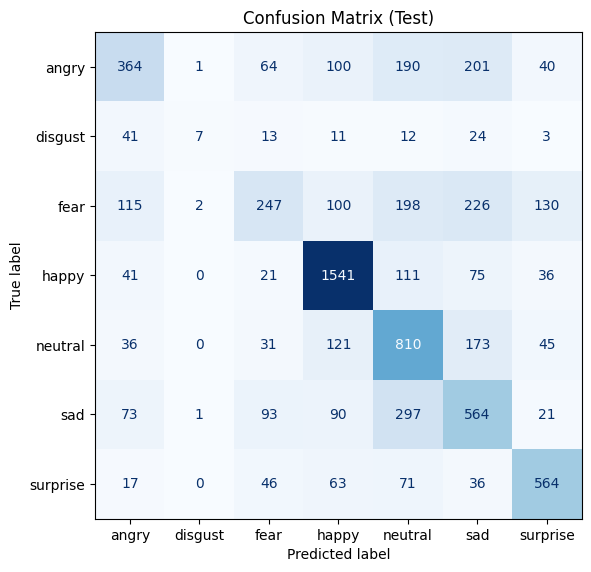

Macro ROC-AUC: 0.872456
Top-3 Accuracy: 0.875035 | Top-5 Accuracy: 0.976790


In [6]:
# 3) Quick eval (loss/acc) using Keras
loss, acc = saved.evaluate(test_ds, verbose=0)
print(f"Test Loss: {loss:.6f} | Test Accuracy: {acc:.6f}")

# 4) Collect all test batches (numpy already)
#    test_ds.labels are integer class ids; test_ds.classes is an alias
y_true_int = test_ds.classes.astype(int)
# If categorical, also make one-hot for ROC-AUC / top-k
y_true_1h = tf.keras.utils.to_categorical(y_true_int, num_classes=len(class_names))

# Predict probabilities for all samples
y_prob = saved.predict(test_ds, verbose=0)
y_pred_int = np.argmax(y_prob, axis=1)

# 5) Metrics
print("\nDetailed classification report:")
print(classification_report(y_true_int, y_pred_int, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_int, y_pred_int, labels=range(len(class_names)))
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# Macro ROC-AUC (one-vs-rest) — works with one-hot labels
try:
    auc_macro = roc_auc_score(y_true_1h, y_prob, multi_class="ovr", average="macro")
    print(f"Macro ROC-AUC: {auc_macro:.6f}")
except Exception as e:
    print("ROC-AUC not available:", e)

# Top-k accuracy (Top-3 / Top-5)
top3 = tf.keras.metrics.top_k_categorical_accuracy(y_true_1h, tf.convert_to_tensor(y_prob), k=3).numpy().mean()
top5 = tf.keras.metrics.top_k_categorical_accuracy(y_true_1h, tf.convert_to_tensor(y_prob), k=5).numpy().mean()
print(f"Top-3 Accuracy: {top3:.6f} | Top-5 Accuracy: {top5:.6f}")


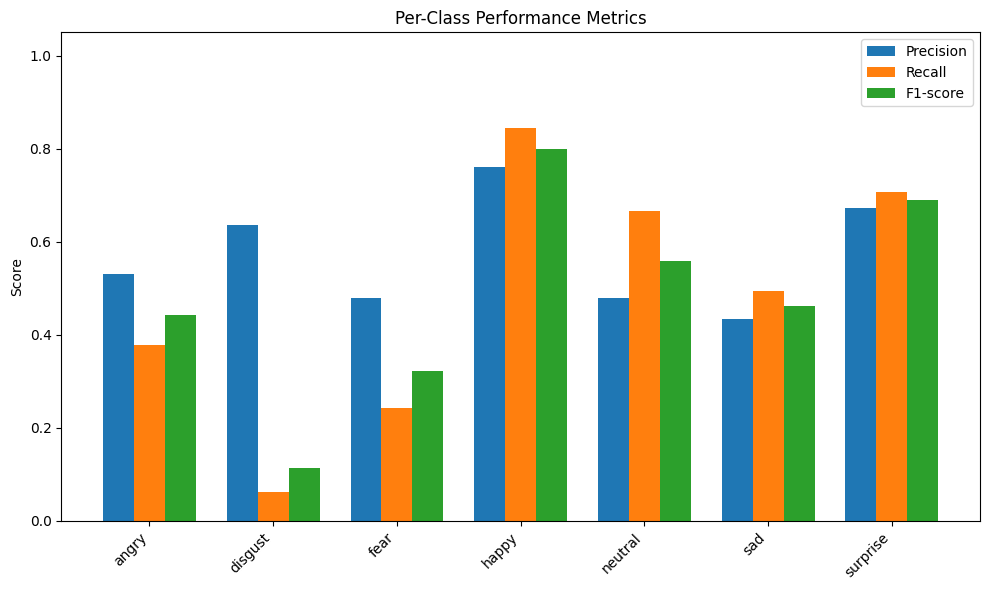

In [7]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_int, y_pred_int, labels=range(len(class_names))
)

x = np.arange(len(class_names))  # class indices
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, prec, width, label="Precision")
ax.bar(x, rec, width, label="Recall")
ax.bar(x + width, f1, width, label="F1-score")

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Per-Class Performance Metrics")
ax.legend()
plt.tight_layout()
plt.show()

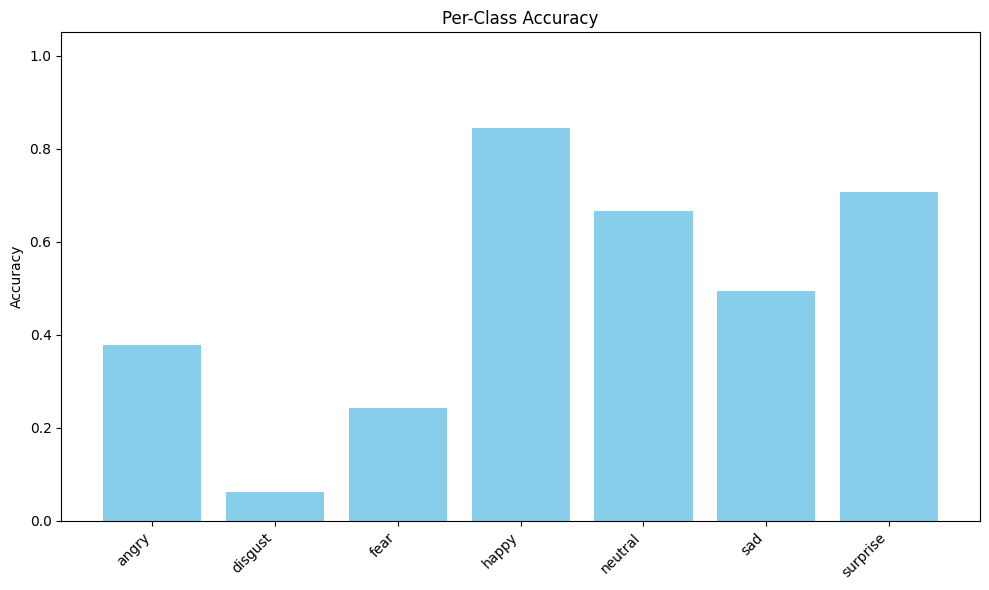

In [8]:
class_acc = []
for i, cls in enumerate(class_names):
    # all samples of this class
    idx = np.where(y_true_int == i)[0]
    if len(idx) > 0:
        acc = np.mean(y_pred_int[idx] == y_true_int[idx])
    else:
        acc = np.nan  # in case a class has no samples
    class_acc.append(acc)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(class_names, class_acc, color="skyblue")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy")
ax.set_title("Per-Class Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Happy class is the best perfoming class
